In [1]:
!pip install torch torchvision matplotlib numpy

In [2]:
!unzip helmet_classify_img.zip -d dataset

Archive:  helmet_classify_img.zip
   creating: dataset/helmet_classify_img/helmet/
  inflating: dataset/helmet_classify_img/helmet/0x0.jpg  
  inflating: dataset/helmet_classify_img/helmet/20211017_interesting-facts-about-the-design-and-use-of-motorcycle-helmets-scaled.jpg  
  inflating: dataset/helmet_classify_img/helmet/21936_jpg.rf.f0693848527a6a379793cce1391889e0.jpg  
  inflating: dataset/helmet_classify_img/helmet/22003_jpg.rf.3c23a6b5c5ba150f81a75e43bc5ecdc7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22062_jpg.rf.0e5810ca6b1968802e0240d894704a56.jpg  
  inflating: dataset/helmet_classify_img/helmet/22086_jpg.rf.8c424f9599c686155584370a8d57d5cf.jpg  
  inflating: dataset/helmet_classify_img/helmet/22088_jpg.rf.f65011c58af100217efb18ccf461fd1a.jpg  
  inflating: dataset/helmet_classify_img/helmet/22095_jpg.rf.bd0a2569a75519bbe3ba86e0c1a8e9d7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22112_jpg.rf.89ae411ec9ec03af0dc2ad9b9c787c3a.jpg  
  inflating: dataset/hel

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Importing dataset

## Augmentations

In [5]:
aug_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 20)),
    v2.ColorJitter(brightness=.5, hue=.3),
    v2.RandomAutocontrast(),
    transforms.ToTensor()
])
org_transform = v2.Compose([
    v2.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
data_path = "dataset/helmet_classify_img"
dataset = datasets.ImageFolder(root=data_path, transform=org_transform)
aug_ds = datasets.ImageFolder(root=data_path, transform=aug_transform)

### Concatenate original and augmented datasets

In [7]:
combined_dataset = ConcatDataset([dataset, aug_ds])

In [8]:
class_names = ["helmet", "no_helmet"]

In [9]:
def visualize_batch(batch):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
    for idx, im in enumerate(batch[0][:5]):
        im = im.numpy().transpose((1, 2, 0))
        ax[idx].imshow(im)
        ax[idx].title.set_text(batch[1][idx])

## Splitting data

In [10]:
val_size = 0.1
test_size = 0.2
val_len = int(val_size * len(combined_dataset))
test_len = int(test_size * len(combined_dataset))
train_len = len(combined_dataset) - val_len - test_len

In [11]:
train_set, val_set, test_set = random_split(combined_dataset, [train_len, val_len, test_len])

In [12]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [13]:
batch = next(iter(train_loader))
print(batch[0][0].shape)

torch.Size([3, 224, 224])


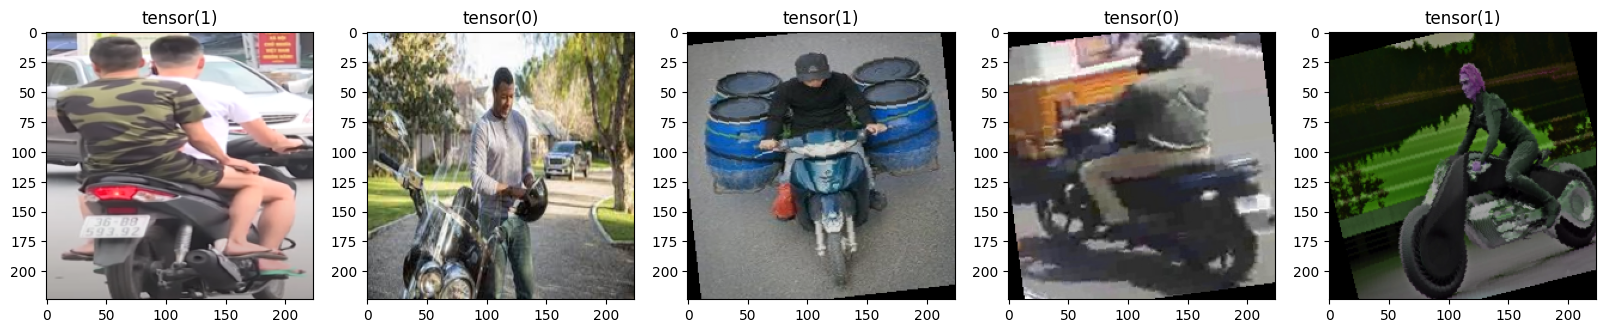

In [14]:
visualize_batch(batch)

In [15]:
len(train_loader)

16

# Models

In [25]:
num_classes = len(dataset.classes)
googlenet_model = models.squeezenet1_0(pretrained=True)
#googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
#googlenet_model.classifier[-1] = nn.Linear(googlenet_model.classifier[-1].in_features, num_classes)
googlenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
googlenet_model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet_model.parameters(), lr=0.001, momentum=0.9)

In [27]:
num_epochs = 100

training_history = {'loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    googlenet_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Validation
    googlenet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)

    training_history['loss'].append(average_train_loss)
    training_history['val_loss'].append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')

# Save model
torch.save(googlenet_model.state_dict(), 'squeezenet_finetuned.pth')

Epoch [1/100], Train Loss: 0.6782, Val Loss: 0.6131
Epoch [2/100], Train Loss: 0.5782, Val Loss: 0.5934
Epoch [3/100], Train Loss: 0.5995, Val Loss: 0.5775
Epoch [4/100], Train Loss: 0.5903, Val Loss: 0.5582
Epoch [5/100], Train Loss: 0.5495, Val Loss: 0.5228
Epoch [6/100], Train Loss: 0.4664, Val Loss: 0.5560
Epoch [7/100], Train Loss: 0.4211, Val Loss: 0.8297
Epoch [8/100], Train Loss: 0.4118, Val Loss: 0.7292
Epoch [9/100], Train Loss: 0.4137, Val Loss: 0.5315
Epoch [10/100], Train Loss: 0.4166, Val Loss: 0.6013
Epoch [11/100], Train Loss: 0.3924, Val Loss: 0.4617
Epoch [12/100], Train Loss: 0.3118, Val Loss: 0.5884
Epoch [13/100], Train Loss: 0.2846, Val Loss: 0.4050
Epoch [14/100], Train Loss: 0.2084, Val Loss: 0.4934
Epoch [15/100], Train Loss: 0.2857, Val Loss: 0.4418
Epoch [16/100], Train Loss: 0.3986, Val Loss: 0.6227
Epoch [17/100], Train Loss: 0.3549, Val Loss: 0.5110
Epoch [18/100], Train Loss: 0.2828, Val Loss: 0.7478
Epoch [19/100], Train Loss: 0.2525, Val Loss: 0.5915
Ep

### Plotting loss

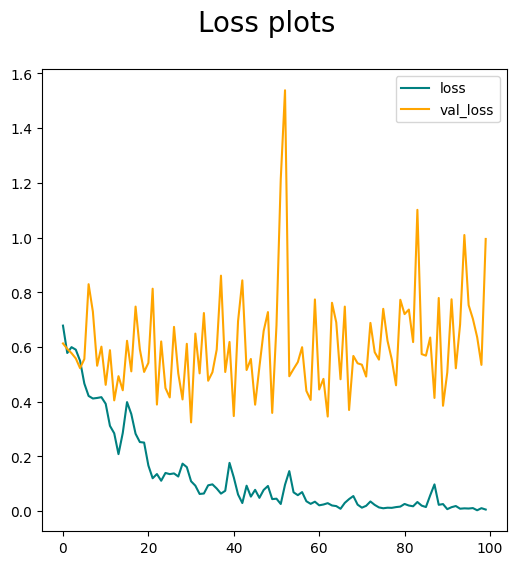

In [28]:
fig = plt.figure(figsize=(6, 6))

plt.plot(training_history['loss'], color='teal', label='loss')
plt.plot(training_history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Loss plots', fontsize=20)
plt.legend(loc="upper right")
plt.show()

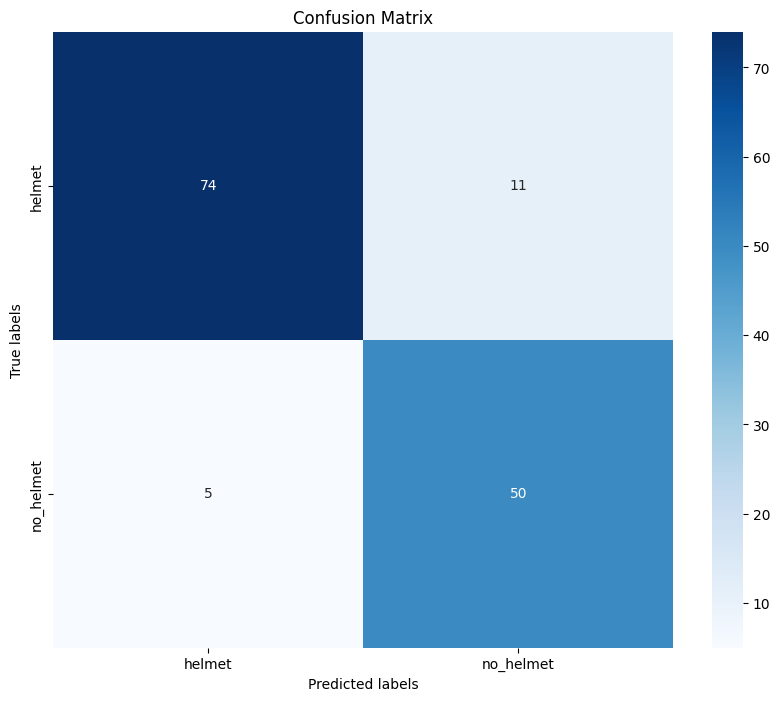

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
googlenet_model.eval()

# Move model to CPU (if it was trained on GPU)
googlenet_model = googlenet_model.to("cpu")

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

start_time = time.time()
# Testing loop
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = googlenet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
end_test_time = time.time()

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['helmet', 'no_helmet']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
from sklearn.metrics import f1_score, recall_score, precision_score
print(f"f1: {f1_score(true_labels, predicted_labels)}, precision: {precision_score(true_labels, predicted_labels)}, recall: {recall_score(true_labels, predicted_labels)}")

print(f"Test reference time: {end_test_time - start_time} - Total examples: {len(test_set) * 32} - Avg: {(end_test_time - start_time) / (len(test_set) * 32)}")

f1: 0.8620689655172413, precision: 0.819672131147541, recall: 0.9090909090909091
Test reference time: 9.853958368301392 - Total examples: 4480 - Avg: 0.0021995442786387036
